# User subreddit Embeddings: Vector representations of users' subreddit histories

## Setup

In [2]:
import json
import numpy as np
from scipy.sparse import bsr_matrix, coo_matrix, csr_matrix, lil_matrix, identity
from matplotlib import pyplot as plt

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

In [3]:
# with open("stored_variables/politics_author_history.json", "r") as f:
#     politics_author_history = json.load(f)
with open("stored_variables/politics_author_history2.json", "r") as f:
    politics_author_history = json.load(f)

In [4]:
input_subreddit_list = []
author_names = []

for k in politics_author_history.keys():
    input_subreddit_list.append(sorted(politics_author_history[k], key = lambda x : x[1]))
    author_names.append(k)

In [5]:
input_subreddit_list = [[x[0] for x in l] for l in input_subreddit_list]

In [6]:
color_vals = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'cyan', 'magenta', 'yellow', 'brown']

In [7]:
all_subreddits = sorted(list(set([i for l in input_subreddit_list for i in l])))
subreddit_reverse_dict = {all_subreddits[i] : i for i in range(len(all_subreddits))}

In [8]:
tf_indptr = [0]
tf_indices = []
tf_data = []

df_indptr = [0]
df_indices = []
df_data = []

for lst in input_subreddit_list:
    for s in lst:
        index = subreddit_reverse_dict[s]
        tf_indices.append(index)
        tf_data.append(1)
        
    for s in set(lst):
        index = subreddit_reverse_dict[s]
        df_indices.append(index)
        df_data.append(1)
        
    tf_indptr.append(len(tf_indices))
    df_indptr.append(len(df_indices))

In [9]:
subreddit_tf = csr_matrix((tf_data, tf_indices, tf_indptr))
subreddit_df_mat = csr_matrix((df_data, df_indices, df_indptr))

In [10]:
subreddit_tf

<20000x41900 sparse matrix of type '<class 'numpy.int64'>'
	with 30276925 stored elements in Compressed Sparse Row format>

In [11]:
csr_matrix(coo_matrix(subreddit_tf))

<20000x41900 sparse matrix of type '<class 'numpy.int64'>'
	with 1327204 stored elements in Compressed Sparse Row format>

In [12]:
# combine entries
subreddit_tf = csr_matrix(coo_matrix(subreddit_tf))

In [13]:
print(len(np.array(np.sum(subreddit_tf, axis=0).transpose())))
print(len(all_subreddits))
print(subreddit_tf.shape)
print(subreddit_df_mat.shape)

41900
41900
(20000, 41900)
(20000, 41900)


In [14]:
subreddit_df = subreddit_df_mat.sum(axis=0)
subreddit_idf = len(input_subreddit_list) / subreddit_df

In [15]:
print(subreddit_df.shape)
print(subreddit_idf.shape)

(1, 41900)
(1, 41900)


In [16]:
subreddit_tfidf = subreddit_tf.multiply(subreddit_idf)

In [17]:
subreddit_tfidf = subreddit_tfidf / subreddit_tfidf.sum(axis=1)

In [18]:
print(subreddit_tfidf.shape)
print(subreddit_tfidf.sum(axis=1).shape)

(20000, 41900)
(20000, 1)


In [19]:
subreddit_freqs = np.array(subreddit_tf.sum(axis=0))[0]

In [20]:
subreddit_df

matrix([[ 1,  1,  1, ...,  2, 13,  2]], dtype=int64)

In [21]:
subreddit_df_arr = np.array(subreddit_df)[0]

In [22]:
np.sum(subreddit_df_arr >= 10)

8447

In [23]:
# only use subreddits that at least 100 people have commented in 
good_subreddits = [i for i in range(len(all_subreddits)) if subreddit_df_arr[i] >= 100 and all_subreddits[i] != 'politics']
good_subreddit_names = [all_subreddits[i] for i in good_subreddits]
good_subreddit_reverse_dict = {good_subreddit_names[i] : i for i in range(len(good_subreddit_names))}
print(len(good_subreddits))

1738


In [24]:
subreddit_tf_good = subreddit_tf[:, good_subreddits]
subreddit_df_good = subreddit_df_mat[:, good_subreddits]
subreddit_tfidf_good = subreddit_tfidf[:, good_subreddits]

## Descriptive statistics

(array([1.9203e+04, 6.0200e+02, 1.3600e+02, 3.3000e+01, 1.5000e+01,
        4.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.20820e+03, 1.44154e+04, 2.16226e+04, 2.88298e+04,
        3.60370e+04, 4.32442e+04, 5.04514e+04, 5.76586e+04, 6.48658e+04,
        7.20730e+04]),
 <a list of 10 Patch objects>)

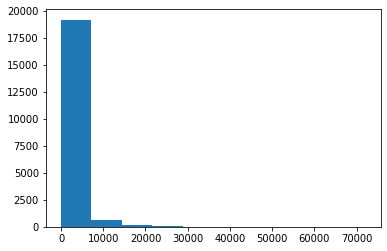

In [25]:
history_lengths = [len(l) for l in input_subreddit_list]

plt.hist(history_lengths)

(array([9754., 3260., 1734., 1166.,  799.,  598.,  409.,  377.,  273.,
         223.]),
 array([1.0000e+00, 5.0070e+02, 1.0004e+03, 1.5001e+03, 1.9998e+03,
        2.4995e+03, 2.9992e+03, 3.4989e+03, 3.9986e+03, 4.4983e+03,
        4.9980e+03]),
 <a list of 10 Patch objects>)

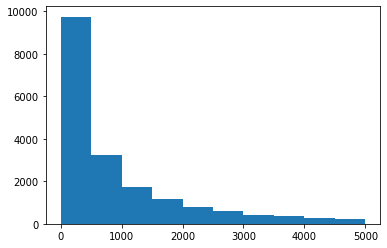

In [26]:
plt.hist([i for i in history_lengths if i < 5000])

(array([4048., 2071., 1487., 1149.,  995.,  888.,  706.,  598.,  546.,
         519.]),
 array([  1. , 100.8, 200.6, 300.4, 400.2, 500. , 599.8, 699.6, 799.4,
        899.2, 999. ]),
 <a list of 10 Patch objects>)

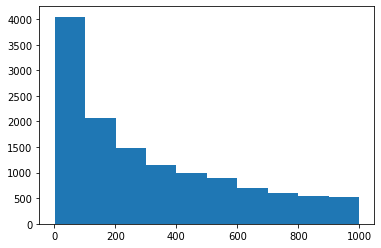

In [27]:
plt.hist([i for i in history_lengths if i < 1000])

In [28]:
print("Mean history length:", np.mean(history_lengths))
print("Median history length:", np.median(history_lengths))
print("Standard deviation of history lengths:", np.std(history_lengths))
print("Total number of comments:", sum(history_lengths))

Mean history length: 1513.84625
Median history length: 526.0
Standard deviation of history lengths: 2977.5964636449544
Total number of comments: 30276925


### Top subreddits

In [ ]:
top_subreddits = [(all_subreddits[i], int(subreddit_freqs[i])) for i in np.argsort(subreddit_freqs)]
top_subreddits.reverse()

for i in top_subreddits[:50]:
    print(i[0] + ": " + str(i[1]))

In [33]:
print(subreddit_freqs[subreddit_reverse_dict['The_Donald']])
print(subreddit_freqs[subreddit_reverse_dict['SandersForPresident']])
print(subreddit_freqs[subreddit_reverse_dict['hillaryclinton']])

96076
172796
14581


In [ ]:
top_subreddits_df = [(all_subreddits[i], int(subreddit_df_arr[i])) for i in np.argsort(subreddit_df_arr)]
top_subreddits_df.reverse()

for i in top_subreddits_df[:50]:
    print(i[0] + ": " + str(i[1]))

In [34]:
print(subreddit_df_arr[subreddit_reverse_dict['The_Donald']])
print(subreddit_df_arr[subreddit_reverse_dict['SandersForPresident']])
print(subreddit_df_arr[subreddit_reverse_dict['hillaryclinton']])

3354
5473
688


In [ ]:
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).sum())

## Create Doc2Vec embeddings of the subreddits

In [200]:
user_docs = [TaggedDocument(input_subreddit_list[i], [author_names[i]]) for i in range(len(input_subreddit_list))]
subreddit_hist_model = Doc2Vec(user_docs, vector_size=50, window=10, min_count=5)

In [201]:
user_docs[0]

TaggedDocument(words=['reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'programming', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit.com', 'reddit

In [202]:
subreddit_hist_model.docvecs['SolarBear']

array([-0.01574044,  0.24273951, -3.4174132 ,  3.3158882 , -1.5638099 ,
        2.0382042 ,  1.2205406 , -3.4660323 ,  1.7533294 ,  0.68752265,
       -2.3462145 , -2.3560178 , -0.22919981, -1.2605458 ,  0.08028119,
        4.00546   , -2.855865  , -0.94896805,  0.5746349 , -2.4988115 ,
       -0.12526193, -0.6779804 , -0.95171237,  1.1551402 , -0.30171406,
       -0.754352  ,  2.5704935 , -1.2106159 ,  0.16021428,  0.43686712,
        0.15742661,  2.3189037 ,  0.7622124 ,  1.1468732 ,  1.996943  ,
       -2.159578  , -1.8383429 ,  0.8282431 , -2.0767627 ,  1.8826445 ,
        0.61666816, -0.09683297,  2.0419598 ,  2.8554816 , -0.2019907 ,
       -1.8852377 ,  2.8312867 ,  0.9788146 , -0.796319  ,  1.8543861 ],
      dtype=float32)

In [203]:
subreddit_hist_vecs = np.array([subreddit_hist_model.docvecs[i] for i in author_names])

## Visualize document vectors with PCA and T-SNE

In [204]:
subreddit_doc2vec_pca = PCA(n_components=2)
subreddit_doc2vec_pca_points = subreddit_doc2vec_pca.fit_transform(subreddit_hist_vecs)
subreddit_doc2vec_pca.explained_variance_ratio_

array([0.08170319, 0.04923902], dtype=float32)

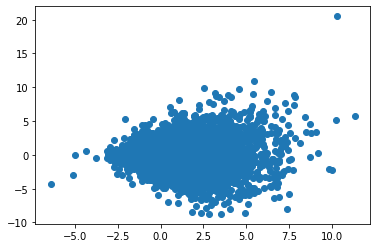

In [205]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1])
plt.show()

In [213]:
subreddit_tsne = TSNE(n_components=2)
subreddit_tsne_points = subreddit_tsne.fit_transform(subreddit_hist_vecs)

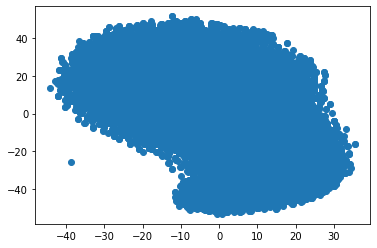

In [214]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1])
plt.show()

## K-means clustering

In [37]:
km2 = KMeans(n_clusters=2)
km2.fit(subreddit_hist_vecs)
km2_labels = km2.labels_
km2_label_colors = [color_vals[i] for i in km2_labels]

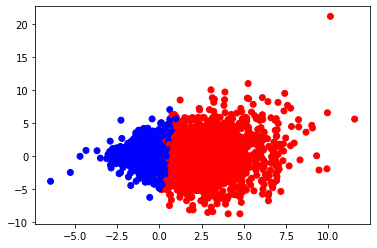

In [39]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], c=km2_label_colors)
plt.show()

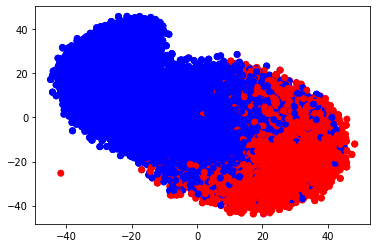

In [40]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1], c=km2_label_colors)
plt.show()

In [42]:
km3 = KMeans(n_clusters=3)
km3.fit(subreddit_hist_vecs)
km3_label_colors = [color_vals[i] for i in km3.labels_]

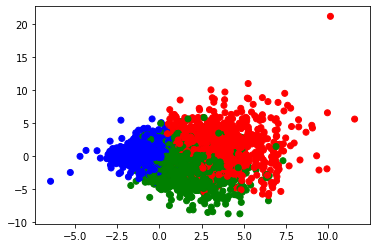

In [43]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], c=km3_label_colors)
plt.show()

In [44]:
km4 = KMeans(n_clusters=4)
km4.fit(subreddit_hist_vecs)
km4_label_colors = [color_vals[i] for i in km4.labels_]

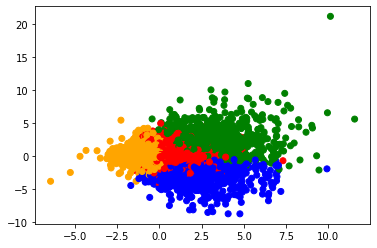

In [45]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], c=km4_label_colors)
plt.show()

## Community2Vec (Using PPMI)

In [40]:
co_freq_mat = (subreddit_tf_good.T).dot(subreddit_tf_good)
co_exist_mat = (subreddit_df_good.T).dot(subreddit_df_good)

In [41]:
subreddit_df_sums = subreddit_df_good.sum(axis=0)
pmi_denom = (subreddit_df_sums.T).dot(subreddit_df_sums)

In [42]:
pmi_mat = len(input_subreddit_list) * np.array(co_exist_mat) / np.array(pmi_denom)
ppmi_mat = np.where(pmi_mat > 1, pmi_mat, 1)
ppmi_mat = np.log2(ppmi_mat)
ppmi_mat = ppmi_mat / np.linalg.norm(ppmi_mat, 2, axis=1)[:, np.newaxis]

In [43]:
ppmi_sims = np.matmul(ppmi_mat, ppmi_mat.T)

In [44]:
pmi_mat = np.array(pmi_mat)

In [187]:
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['The_Donald']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['nba']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['news']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['Music']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_mat[good_subreddit_reverse_dict['sanfrancisco']])[-10:]])

['60fpsporn', 'CringeAnarchy', 'subredditcancer', 'AgainstHateSubreddits', 'sweden', 'european', 'HillaryForPrison', 'AskTrumpSupporters', 'Mr_Trump', 'The_Donald']
['sweden', 'Blackout2015', 'Mr_Trump', 'AskTrumpSupporters', 'enoughsandersspam', 'PanamaPapers', 'HillaryForPrison', 'hillaryclinton', 'GrassrootsSelect', 'SandersForPresident']
['AskTrumpSupporters', 'PoliticalDiscussion', 'AgainstHateSubreddits', 'GamerGhazi', 'badeconomics', 'HillaryForPrison', 'democrats', 'GrassrootsSelect', 'enoughsandersspam', 'hillaryclinton']
['bostonceltics', 'chicagobulls', 'NBA2k', 'NYKnicks', 'warriors', 'nbastreams', 'lakers', 'heat', 'clevelandcavs', 'nba']
['Bad_Cop_No_Donut', 'worstof', 'inthenews', 'modnews', 'onions', 'asianamerican', 'TopMindsOfReddit', 'evolutionReddit', 'Blackout2015', 'news']
['vinyl', 'WeAreTheMusicMakers', 'beatles', 'radiohead', 'indieheads', 'progmetal', 'pinkfloyd', 'futurebeats', 'LetsTalkMusic', 'Music']
['worldevents', 'sailing', 'ExposurePorn', '49ers', 'sur

In [133]:
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['The_Donald']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['SandersForPresident']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['hillaryclinton']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['Conservative']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['nba']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['news']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['Music']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_sims[good_subreddit_reverse_dict['sanfrancisco']])[-10:]])

['punchablefaces', 'Tinder', 'TumblrInAction', 'pussypassdenied', 'KotakuInAction', 'ImGoingToHellForThis', 'CringeAnarchy', 'SandersForPresident', 'BlackPeopleTwitter', 'The_Donald']
['facepalm', 'BlackPeopleTwitter', 'cringepics', 'television', 'UpliftingNews', 'quityourbullshit', 'gifs', 'reactiongifs', 'Showerthoughts', 'SandersForPresident']
['news', 'changemyview', 'ShitRedditSays', 'SubredditDrama', 'circlebroke', 'Conservative', 'enoughsandersspam', 'SandersForPresident', 'PoliticalDiscussion', 'hillaryclinton']
['Bad_Cop_No_Donut', 'changemyview', 'worldpolitics', 'MensRights', 'conspiracy', 'Republican', 'PoliticalHumor', 'news', 'Libertarian', 'Conservative']
['soccer', 'Boxing', 'hiphopheads', 'Patriots', 'hockey', 'CFB', 'sports', 'nfl', 'baseball', 'nba']
['pics', 'JusticePorn', 'conspiracy', 'videos', 'nottheonion', 'bestof', 'todayilearned', 'explainlikeimfive', 'worldnews', 'news']
['AdviceAnimals', 'movies', 'todayilearned', 'WTF', 'AskReddit', 'IAmA', 'funny', 'pics'

In [134]:
print(ppmi_sims[good_subreddit_reverse_dict['The_Donald'], good_subreddit_reverse_dict['SandersForPresident']])
print(ppmi_sims[good_subreddit_reverse_dict['The_Donald'], good_subreddit_reverse_dict['hillaryclinton']])
print(ppmi_sims[good_subreddit_reverse_dict['SandersForPresident'], good_subreddit_reverse_dict['hillaryclinton']])

0.8929025628740377
0.6933783419110202
0.7883338109239759


In [135]:
ppmi_pca = TruncatedSVD(n_components=50)
ppmi_pca_points = ppmi_pca.fit_transform(ppmi_mat)
ppmi_pca.explained_variance_ratio_

array([0.02524376, 0.12219515, 0.07727974, 0.06385116, 0.04266636,
       0.02958324, 0.02488884, 0.01927842, 0.01709296, 0.01490517,
       0.01240546, 0.01225742, 0.01004616, 0.0085419 , 0.00764723,
       0.00728166, 0.00708174, 0.00639021, 0.00576469, 0.00560379,
       0.00532902, 0.0046157 , 0.00432335, 0.00413768, 0.00403899,
       0.00387088, 0.00382585, 0.00373267, 0.00348634, 0.00341844,
       0.00336248, 0.00311427, 0.00305929, 0.00296553, 0.00295873,
       0.00289493, 0.00279086, 0.00272006, 0.00269177, 0.00263791,
       0.00260935, 0.00256482, 0.00249706, 0.0024344 , 0.00236888,
       0.00231289, 0.00230501, 0.00224156, 0.00217003, 0.00215801])

In [178]:
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[0])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[1])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[2])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[3])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[4])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[5])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[6])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[7])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[8])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[9])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[10])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[11])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[12])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[13])[-20:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca.components_[14])[-20:]])

['itsaunixsystem', 'Braveryjerk', 'futureporn', 'IsItBullshit', 'lolcats', 'worstof', 'MMFB', 'NoShitSherlock', 'facebookwins', 'ThingsCutInHalfPorn', 'DestructionPorn', 'ofcoursethatsathing', 'EditingAndLayout', 'Offensive_Wallpapers', 'illusionporn', 'RedditThroughHistory', 'Frugal_Jerk', 'AdPorn', 'newreddits', 'modnews']
['GrandTheftAutoV_PC', 'witcher', 'smashbros', 'JonTron', 'bloodborne', 'archeage', 'yugioh', 'StreetFighter', 'Smite', 'montageparodies', 'Cynicalbrit', 'DarkSouls2', 'Overwatch', 'darksouls3', 'LivestreamFails', 'GiftofGames', 'paydaytheheist', 'MonsterHunter', 'bladeandsoul', 'Warframe']
['Colts', 'Texans', 'eagles', 'KansasCityChiefs', 'cowboys', 'clevelandcavs', 'nyjets', 'AZCardinals', 'Chargers', 'Madden', 'bengals', 'Tennesseetitans', 'Saints', 'Browns', 'oaklandraiders', 'bostonceltics', 'NFL_Draft', 'StLouisRams', 'Redskins', 'miamidolphins']
['nexus4', 'sharedota2', 'Ubuntu', 'Dota2Trade', 'linux_gaming', 'opensource', 'Monitors', 'usenet', 'swtor', 'Wil

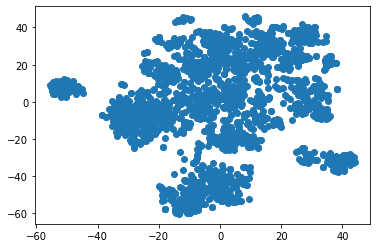

In [136]:
ppmi_tsne = TSNE(n_components=2)
ppmi_tsne_points = ppmi_tsne.fit_transform(ppmi_pca_points)
plt.scatter(ppmi_tsne_points[:,0], ppmi_tsne_points[:,1])
plt.show()

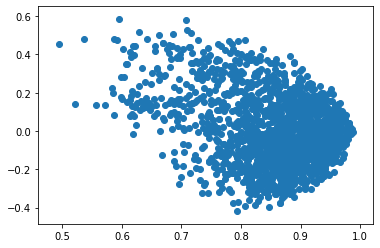

In [137]:
plt.scatter(ppmi_pca_points[:,0], ppmi_pca_points[:,1])
plt.show()

In [138]:
ppmi_pca_norms = np.linalg.norm(ppmi_pca_points, 2, axis = 1)
ppmi_pca_points_normalized = ppmi_pca_points / ppmi_pca_norms[:, np.newaxis]

In [139]:
ppmi_pca_sims = np.matmul(ppmi_pca_points_normalized, ppmi_pca_points_normalized.T)

In [140]:
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['The_Donald']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['SandersForPresident']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['hillaryclinton']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['Conservative']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['Liberal']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['nba']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['lakers']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['news']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['Music']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['AskReddit']])[-10:]])
print([good_subreddit_names[i] for i in np.argsort(ppmi_pca_sims[good_subreddit_reverse_dict['sanfrancisco']])[-10:]])

['KotakuInAction', 'punchablefaces', 'RoastMe', 'pussypassdenied', 'CringeAnarchy', 'HillaryForPrison', 'BlackPeopleTwitter', 'SandersForPresident', 'Mr_Trump', 'The_Donald']
['quityourbullshit', 'nottheonion', 'Tinder', 'gifs', 'television', 'Blackout2015', 'UpliftingNews', 'Showerthoughts', 'HillaryForPrison', 'SandersForPresident']
['circlebroke', 'AskTrumpSupporters', 'SandersForPresident', 'asianamerican', 'GrassrootsSelect', 'Conservative', 'PoliticalVideo', 'PoliticalDiscussion', 'enoughsandersspam', 'hillaryclinton']
['inthenews', 'conspiracy', 'ProtectAndServe', 'Shitstatistssay', 'news', 'PoliticalHumor', 'GunsAreCool', 'Republican', 'Libertarian', 'Conservative']
['socialism', 'lostgeneration', 'law', 'uspolitics', 'Anarchism', 'AnythingGoesNews', 'POLITIC', 'democrats', 'progressive', 'Liberal']
['Seahawks', 'mlb', 'sports', 'Boxing', 'hockey', 'CFB', 'nfl', 'Patriots', 'baseball', 'nba']
['NBA2k', 'rockets', 'bostonceltics', 'chicagobulls', 'heat', 'warriors', 'nbastreams'

In [141]:
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_mat[
    good_subreddit_reverse_dict['The_Donald']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['SandersForPresident']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_mat[
    good_subreddit_reverse_dict['The_Donald']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['hillaryclinton']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_mat[
    good_subreddit_reverse_dict['hillaryclinton']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_mat[
    good_subreddit_reverse_dict['SandersForPresident']], ppmi_mat.T))[-10:]])


['UniversityofReddit', 'architecture', 'secretsanta', 'bayarea', 'AskCulinary', 'Coffee', 'teaching', 'yoga', 'reddit.com', 'femalefashionadvice']
['sadcringe', 'european', 'blackops3', 'CLG', 'trashyboners', 'darksouls3', 'CoonTown', 'AskTrumpSupporters', 'Mr_Trump', 'The_Donald']
['femalefashionadvice', 'serialpodcast', 'Ask_Politics', 'Screenwriting', 'NeutralPolitics', 'GradSchool', 'democrats', 'PoliticalDiscussion', 'education', 'hillaryclinton']
['cumsluts', 'milf', 'asstastic', 'BlackPeopleTwitter', '60fpsporn', 'holdthemoan', 'GirlsFinishingTheJob', 'PetiteGoneWild', 'trashyboners', 'The_Donald']
['RealGirls', 'GirlsFinishingTheJob', 'asstastic', 'carporn', 'millionairemakers', 'NSFW_GIF', 'Celebs', 'nsfw_gifs', 'PetiteGoneWild', 'BustyPetite']
['Ask_Politics', 'survivor', 'chicagobulls', 'StLouisRams', 'NFL_Draft', 'democrats', 'enoughsandersspam', 'badeconomics', 'PoliticalDiscussion', 'hillaryclinton']


In [149]:
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_mat[
    good_subreddit_reverse_dict['The_Donald']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['SandersForPresident']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_mat[
    good_subreddit_reverse_dict['The_Donald']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['hillaryclinton']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_mat[
    good_subreddit_reverse_dict['hillaryclinton']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_mat[
    good_subreddit_reverse_dict['SandersForPresident']]))


4.3635540216276105
-4.3635540216276105
-2.374480544197593
2.374480544197593
6.7380345658252025
-6.7380345658252025


In [142]:
ppmi_pca_points_normalized[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['The_Donald']]

array([ 0.1037045 , -0.15603724, -0.00237527,  0.13021642, -0.02058913,
        0.09345297, -0.14506462,  0.02910889,  0.10684993,  0.05262176,
       -0.03620532,  0.02730861,  0.00951867,  0.01480599,  0.01543015,
        0.03955563, -0.0285987 , -0.06080715, -0.04212779,  0.01871639,
        0.03705303,  0.02143688,  0.03652559,  0.04043988, -0.0079379 ,
       -0.00224014, -0.00635641, -0.02605284, -0.0292075 ,  0.00719681,
        0.02920695, -0.00632352,  0.01036555, -0.00026808, -0.0042486 ,
       -0.01434296, -0.00956869,  0.03295749, -0.01428039,  0.01129135,
       -0.06581136, -0.01946195, -0.0123159 ,  0.00880249, -0.01625484,
       -0.0068189 , -0.01784155,  0.02794769, -0.0185278 , -0.00441778])

In [143]:
np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['The_Donald']], ppmi_pca_points_normalized.T)

array([0.00543698, 0.13725027, 0.08145666, ..., 0.03104855, 0.08416053,
       0.12394751])

In [144]:
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['The_Donald']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['The_Donald']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['SandersForPresident']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['The_Donald']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['The_Donald']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['hillaryclinton']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['hillaryclinton']], ppmi_pca_points_normalized.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_pca_points_normalized[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_pca_points_normalized[
    good_subreddit_reverse_dict['SandersForPresident']], ppmi_pca_points_normalized.T))[-10:]])


['education', 'architecture', 'Coffee', 'booksuggestions', 'kindle', 'reddit.com', 'GradSchool', 'yoga', 'teaching', 'femalefashionadvice']
['sadcringe', 'Rainbow6', 'darksouls3', 'AskTrumpSupporters', 'CLG', 'trashyboners', 'blackops3', 'CoonTown', 'Mr_Trump', 'The_Donald']
['NeutralPolitics', 'femalefashionadvice', 'democrats', 'Screenwriting', 'serialpodcast', 'Ask_Politics', 'GradSchool', 'PoliticalDiscussion', 'education', 'hillaryclinton']
['nsfw_gifs', '60fpsporn', 'AsiansGoneWild', 'cumsluts', 'milf', 'The_Donald', 'asstastic', 'GirlsFinishingTheJob', 'PetiteGoneWild', 'trashyboners']
['Amateur', 'milf', 'BustyPetite', 'GoneMild', 'tightdresses', 'nsfw_gifs', 'carporn', 'asstastic', 'GirlsFinishingTheJob', 'PetiteGoneWild']
['NFL_Draft', 'chicagobulls', 'StLouisRams', 'AskFeminists', 'CapitalismVSocialism', 'democrats', 'badeconomics', 'Ask_Politics', 'PoliticalDiscussion', 'hillaryclinton']


In [54]:
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['Mr_Trump']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['Mr_Trump']] - ppmi_mat[
    good_subreddit_reverse_dict['The_Donald']], ppmi_mat.T))[-10:]])



['GamePhysics', 'montageparodies', 'h3h3productions', 'pcmasterrace', 'GlobalOffensive', 'meirl', 'me_irl', 'BlackPeopleTwitter', 'millionairemakers', 'The_Donald']
['teaching', 'Minneapolis', 'Pathfinder_RPG', 'uspolitics', 'Permaculture', 'Teachers', 'TheGirlSurvivalGuide', 'femalefashionadvice', 'education', 'Mr_Trump']


In [56]:
# Check known relationships
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['nba']] - ppmi_mat[
    good_subreddit_reverse_dict['warriors']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['warriors']] - ppmi_mat[
    good_subreddit_reverse_dict['nba']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['nba']] - ppmi_mat[
    good_subreddit_reverse_dict['chicagobulls']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['chicagobulls']] - ppmi_mat[
    good_subreddit_reverse_dict['nba']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['nfl']] - ppmi_mat[
    good_subreddit_reverse_dict['NFL_Draft']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['NFL_Draft']] - ppmi_mat[
    good_subreddit_reverse_dict['nfl']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['nba']] - ppmi_mat[
    good_subreddit_reverse_dict['sports']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['sports']] - ppmi_mat[
    good_subreddit_reverse_dict['nba']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['Music']] - ppmi_mat[
    good_subreddit_reverse_dict['hiphopheads']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['hiphopheads']] - ppmi_mat[
    good_subreddit_reverse_dict['Music']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['nba']] - ppmi_mat[
    good_subreddit_reverse_dict['nsfw_gifs']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['warriors']] + ppmi_mat[
    good_subreddit_reverse_dict['nsfw_gifs']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['warriors']] - ppmi_mat[
    good_subreddit_reverse_dict['sanfrancisco']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['nba']] + ppmi_mat[
    good_subreddit_reverse_dict['sanfrancisco']], ppmi_mat.T))[-10:]])

print()
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['Fitness']] - ppmi_mat[
    good_subreddit_reverse_dict['running']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['running']] - ppmi_mat[
    good_subreddit_reverse_dict['Fitness']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['Fitness']] - ppmi_mat[
    good_subreddit_reverse_dict['Music']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['Conservative']] - ppmi_mat[
    good_subreddit_reverse_dict['Liberal']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['Liberal']] - ppmi_mat[
    good_subreddit_reverse_dict['Conservative']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['chicagobulls']] - ppmi_mat[
    good_subreddit_reverse_dict['chicago']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['chicago']] - ppmi_mat[
    good_subreddit_reverse_dict['chicagobulls']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['chicagobulls']], ppmi_mat.T))[-10:]])
print([good_subreddit_names[i] for i in np.argsort(np.matmul(ppmi_mat[good_subreddit_reverse_dict['chicago']], ppmi_mat.T))[-10:]])





['RealGirls', 'Celebs', 'curvy', 'trashy', 'NSFW_GIF', '60fpsporn', 'celebnsfw', 'Amateur', 'nsfw_gifs', 'milf']
['Pathfinder_RPG', 'blackdesertonline', 'rockets', 'archeage', 'CompetitiveHS', 'EDH', 'clevelandcavs', 'sportsbook', 'bostonceltics', 'warriors']
['GirlsFinishingTheJob', 'milf', 'OnOff', 'BustyPetite', 'Amateur', 'NSFW_GIF', 'trashy', 'asstastic', 'Celebs', 'RealGirls']
['bostonceltics', 'blackdesertonline', 'Pathfinder_RPG', 'CHIBears', 'CapitalismVSocialism', 'bladeandsoul', 'clevelandcavs', 'CHICubs', 'hawks', 'chicagobulls']
['HistoryPorn', 'curvy', 'gentlemanboners', 'nsfw_gifs', 'OldSchoolCool', 'NSFW_GIF', 'RealGirls', 'nsfw', 'milf', 'Amateur']
['StreetFighter', 'CLG', 'EDH', 'CompetitiveHS', 'archeage', 'oaklandraiders', 'AZCardinals', 'friendsafari', 'fireemblem', 'NFL_Draft']
['warriors', 'nba', 'NFL_Draft', 'fantasyfootball', 'clevelandcavs', 'CollegeBasketball', 'chicagobulls', 'NBA2k', 'lakers', 'NYKnicks']
['homestead', 'history', 'Permaculture', 'Futurology

In [153]:
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['nba']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['nba']] - ppmi_mat[
    good_subreddit_reverse_dict['warriors']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['SandersForPresident']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_mat[
    good_subreddit_reverse_dict['The_Donald']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['The_Donald']] - ppmi_mat[
    good_subreddit_reverse_dict['hillaryclinton']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']] - ppmi_mat[
    good_subreddit_reverse_dict['hillaryclinton']]))
print(np.sum(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']] - ppmi_mat[
    good_subreddit_reverse_dict['SandersForPresident']]))


33.26801378479694
4.81017976740406
-4.3635540216276105
-2.374480544197593
2.374480544197593
6.7380345658252025
-6.7380345658252025


In [188]:
print(ppmi_pca.transform(ppmi_mat[good_subreddit_reverse_dict['SandersForPresident']].reshape(1,-1)))
print(ppmi_pca.transform(ppmi_mat[good_subreddit_reverse_dict['The_Donald']].reshape(1,-1)))
print(ppmi_pca.transform(ppmi_mat[good_subreddit_reverse_dict['hillaryclinton']].reshape(1,-1)))
print(ppmi_pca.transform(ppmi_mat[good_subreddit_reverse_dict['milf']].reshape(1,-1)))
print(ppmi_pca.transform((ppmi_mat[good_subreddit_reverse_dict['nba']] - ppmi_mat[
    good_subreddit_reverse_dict['warriors']]).reshape(1,-1)))

[[ 9.00274258e-01  1.35938383e-01  6.15045094e-02 -1.32513797e-01
   6.66706696e-02 -7.93471824e-02  8.02695740e-03  5.38875009e-03
  -8.56044366e-02  1.02770601e-01 -3.87698295e-02 -1.52495948e-04
   1.08967245e-01  2.84486501e-02 -3.04563885e-02 -1.43275022e-03
   2.95637868e-02 -1.49330248e-01 -6.67209709e-02  7.42607872e-02
  -6.32945152e-02  3.91635426e-02  1.97591906e-03 -2.60715977e-02
   1.44514904e-02 -3.48506876e-02 -3.60046173e-02 -4.60941967e-03
  -8.48986087e-03  3.38976526e-02  1.22842419e-03  5.80815498e-04
   2.18508370e-02 -1.26344169e-02 -8.26386449e-03 -5.32528103e-02
   9.33434393e-03  5.00760054e-02 -1.36548315e-02  3.94604229e-02
  -2.87078250e-02 -3.79460826e-03  1.49430397e-02  4.87015240e-03
  -1.68474194e-02 -5.90736832e-04 -2.31642919e-02  9.44362715e-03
  -2.95119905e-03 -4.81358248e-03]]
[[ 7.93609146e-01  2.85754863e-01  6.33594010e-02 -2.57402268e-01
   8.60899283e-02 -1.69089249e-01  1.48155902e-01 -2.27799033e-02
  -1.88247761e-01  5.11825077e-02 -3.504

## Users most like SandersForPresident, most like The_Donald

In [229]:
print(np.sum(subreddit_tfidf_good.sum(axis=1) == 0))

for i in range(20000):
    if subreddit_tfidf_good[i].sum() == 0:
        print(input_subreddit_list[i])

449
['politics', 'politics']
['politics', 'politics', 'politics']
['politics', 'politics']
['politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politic

['politics']
['yankees', 'politics']
['politics']
['politics']
['politics']
['politics', 'politics']
['politics']
['politics']
['politics']
['politics']
['politics']
['politics', 'politics']
['politics', 'politics']
['politics', 'politics', 'politics']
['politics']
['politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics']
['politics']
['politics']
['politics']
['politics']
['politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics']
['politics', 'politics', 'politics', 'politics', 'politics', 'politics']
['politics']
['politics']
['politics']
['politics']
['politics']
['politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics', 'politics']
['politics']
['politics']
['politics', 'politics', 'politics', 'politics', 'politics'

In [234]:
good_users = [i for i in range(len(input_subreddit_list)) if subreddit_tfidf_good[i].sum() != 0]
subreddit_tfidf_good_normalized = subreddit_tfidf_good[good_users, :] / np.linalg.norm(
    subreddit_tfidf_good[good_users, :], 2, axis=1)[:, np.newaxis]


In [235]:
print(len(good_users))

19551


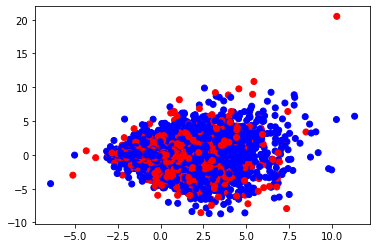

In [270]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], 
            c = [1 if 'The_Donald' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

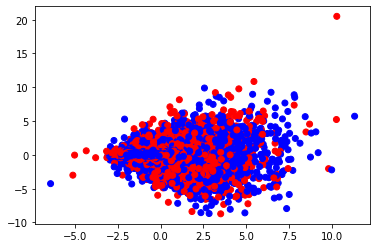

In [271]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], 
            c = [1 if 'SandersForPresident' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

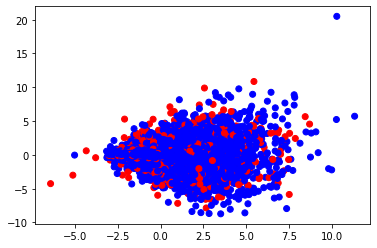

In [272]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], 
            c = [1 if 'nfl' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

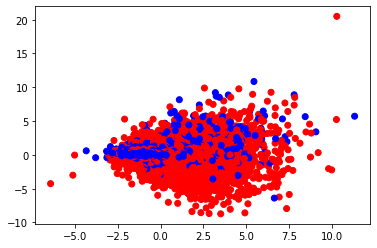

In [276]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], 
            c = [1 if 'gaming' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

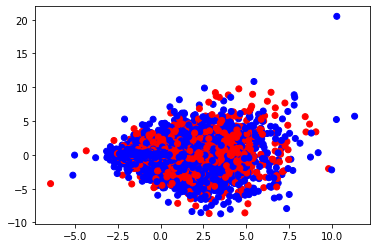

In [277]:
plt.scatter(subreddit_doc2vec_pca_points[:,0], subreddit_doc2vec_pca_points[:,1], 
            c = [1 if 'TwoXChromosomes' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

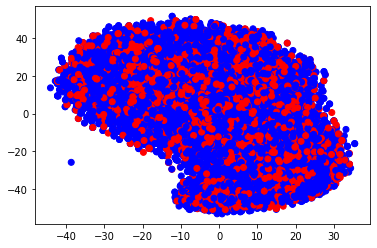

In [273]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1], 
            c = [1 if 'The_Donald' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

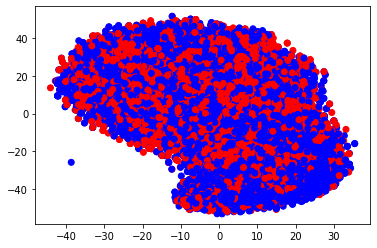

In [274]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1], 
            c = [1 if 'SandersForPresident' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

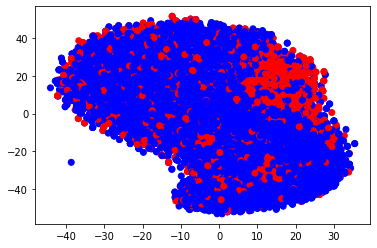

In [275]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1], 
            c = [1 if 'nfl' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

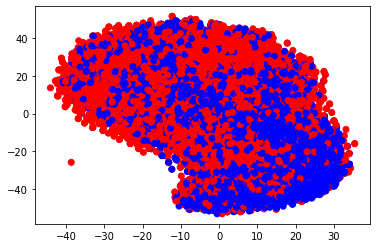

In [278]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1], 
            c = [1 if 'gaming' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

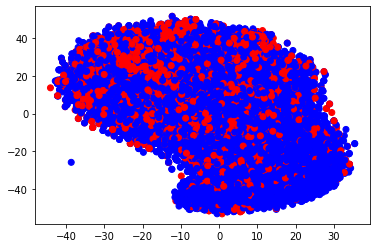

In [279]:
plt.scatter(subreddit_tsne_points[:,0], subreddit_tsne_points[:,1], 
            c = [1 if 'TwoXChromosomes' in i else 0 for i in input_subreddit_list], cmap = plt.cm.bwr)
plt.show()

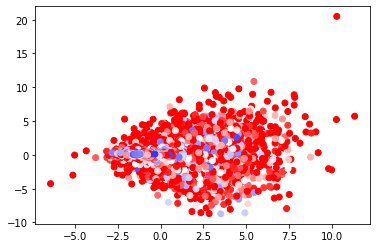

In [257]:
donald_like = np.array(np.matmul(subreddit_tfidf_good_normalized, ppmi_sims[good_subreddit_reverse_dict['The_Donald']].T))[0]
donald_like = np.where(donald_like >=2, 2, donald_like)
donald_like = donald_like / 2

plt.scatter(subreddit_doc2vec_pca_points[good_users,0], subreddit_doc2vec_pca_points[good_users,1], c = donald_like, cmap = plt.cm.bwr)
plt.show()

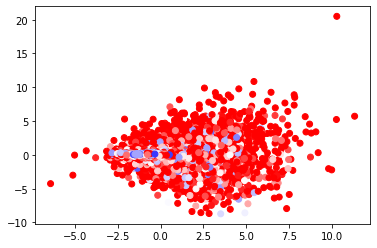

In [258]:
sanders_like = np.array(np.matmul(subreddit_tfidf_good_normalized, ppmi_sims[good_subreddit_reverse_dict['SandersForPresident']].T))[0]
sanders_like = np.where(sanders_like >=2, 2, sanders_like)
sanders_like = sanders_like / 2

plt.scatter(subreddit_doc2vec_pca_points[good_users,0], subreddit_doc2vec_pca_points[good_users,1], c = sanders_like, cmap = plt.cm.bwr)
plt.show()

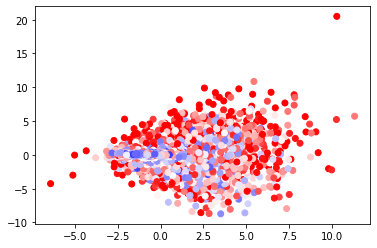

In [261]:
clinton_like = np.array(np.matmul(subreddit_tfidf_good_normalized, ppmi_sims[good_subreddit_reverse_dict['hillaryclinton']].T))[0]
clinton_like = np.where(clinton_like >=2, 2, clinton_like)
clinton_like = clinton_like / 2

plt.scatter(subreddit_doc2vec_pca_points[good_users,0], subreddit_doc2vec_pca_points[good_users,1], c = clinton_like, cmap = plt.cm.bwr)
plt.show()

In [255]:
print(np.argsort(donald_like)[-10:])
print(np.argsort(sanders_like)[-10:])
print(np.argsort(clinton_like)[-10:])


[ 6632  4890 14152  8658  8366   878 15397 16447 16075 12309]
[ 4890  6632 14152  8366  8658   878 15397 16447 16075 12309]
[ 4890 12545 14152  8658  8366   878 16447 15397 16075 12309]


In [252]:
print(good_users[12309])
print(input_subreddit_list[12313])
print(input_subreddit_list[good_users[16075]])

12313
['bestof', 'lewronggeneration', 'lewronggeneration', 'lewronggeneration', 'movies', 'movies', 'news', 'AskMeAnything', 'DAE', 'DAE', 'DAE', 'AskReddit', 'AskMeAnything', 'InternetIsBeautiful', 'wowthissubexists', 'MorbidReality', 'AskReddit', 'Meditation', 'DebateAnAtheist', 'classic4chan', 'shittyaskreddit', 'funny', 'funny', 'funny', 'AdviceAnimals', 'AdviceAnimals', 'AdviceAnimals', 'DAE', 'TalesFromRetail', 'AskReddit', 'discworld', 'xkcd', 'descriptivetitle', 'googlepacman', 'incremental_games', 'ProgrammerHumor', 'ProgrammerHumor', 'DebateAnAtheist', 'nottheonion', 'nottheonion', 'lewronggeneration', 'lewronggeneration', 'lewronggeneration', 'lewronggeneration', 'JustUnsubbed', 'banned', 'mildlyinfuriating', 'badscience', 'f7u12_ham', 'AdviceAnimals', 'philosophy', 'AdviceAnimals', 'pettyrevenge', 'StormfrontorSJW', 'botsrights', 'TumblrInAction', 'explainlikeimfive', 'technology', 'programming', 'programming', 'softwaregore', 'intrusivethoughts', 'WTF', 'WTF', 'dataisbeaut

(array([8.452e+03, 8.057e+03, 2.363e+03, 5.360e+02, 1.060e+02, 2.600e+01,
        4.000e+00, 3.000e+00, 2.000e+00, 2.000e+00]),
 array([0.32901454, 1.25423153, 2.17944851, 3.1046655 , 4.02988248,
        4.95509947, 5.88031645, 6.80553344, 7.73075043, 8.65596741,
        9.5811844 ]),
 <a list of 10 Patch objects>)

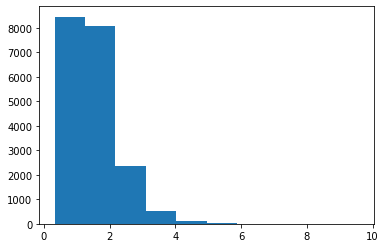

In [256]:
plt.hist(donald_like)

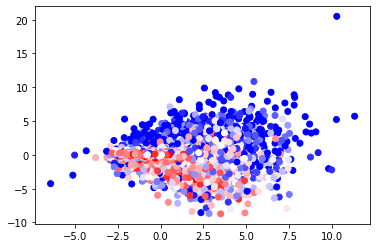

In [266]:
donald_not_sanders = np.array(np.matmul(subreddit_tfidf_good_normalized, 
                                        ppmi_sims[good_subreddit_reverse_dict['The_Donald']].T - ppmi_sims[good_subreddit_reverse_dict['SandersForPresident']].T))[0]
donald_not_sanders = np.where(donald_not_sanders >=0, 0, donald_not_sanders)
donald_not_sanders = np.where(donald_not_sanders <= -0.5, -0.5, donald_not_sanders)
donald_not_sanders = (donald_not_sanders + 0.5) * 2

plt.scatter(subreddit_doc2vec_pca_points[good_users,0], subreddit_doc2vec_pca_points[good_users,1], c = donald_not_sanders, cmap = plt.cm.bwr)
plt.show()

(array([4.000e+00, 6.000e+00, 9.000e+00, 7.400e+01, 2.980e+02, 1.187e+03,
        3.812e+03, 8.326e+03, 5.579e+03, 2.560e+02]),
 array([-1.51766141, -1.34974377, -1.18182612, -1.01390847, -0.84599083,
        -0.67807318, -0.51015554, -0.34223789, -0.17432025, -0.0064026 ,
         0.16151504]),
 <a list of 10 Patch objects>)

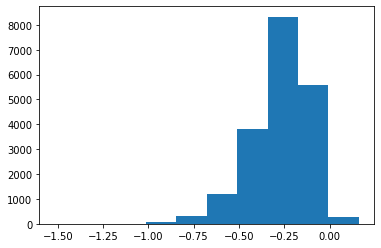

In [262]:
plt.hist(donald_not_sanders)

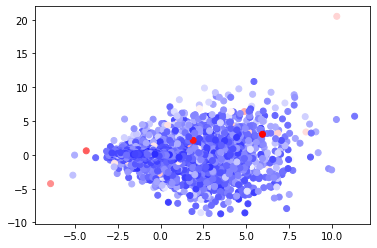

In [240]:
nba_not_warriors = np.array(np.matmul(subreddit_tfidf_good_normalized, 
                                        ppmi_sims[good_subreddit_reverse_dict['nba']].T - ppmi_sims[good_subreddit_reverse_dict['warriors']].T))[0]

plt.scatter(subreddit_doc2vec_pca_points[good_users,0], subreddit_doc2vec_pca_points[good_users,1], c = nba_not_warriors, cmap = plt.cm.bwr)
plt.show()

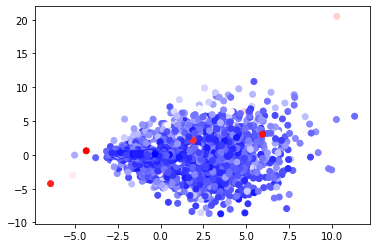

In [241]:
nba_like = np.array(np.matmul(subreddit_tfidf_good_normalized, 
                                        ppmi_sims[good_subreddit_reverse_dict['nba']].T))[0]

plt.scatter(subreddit_doc2vec_pca_points[good_users,0], subreddit_doc2vec_pca_points[good_users,1], c = nba_like, cmap = plt.cm.bwr)
plt.show()

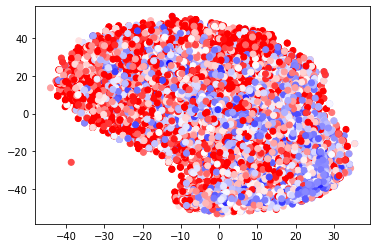

In [259]:
plt.scatter(subreddit_tsne_points[good_users,0], subreddit_tsne_points[good_users,1], c = donald_like, cmap = plt.cm.bwr)
plt.show()

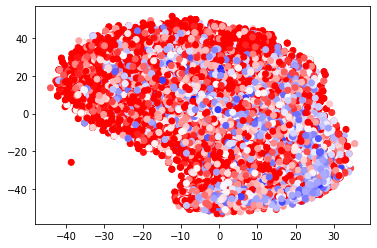

In [260]:
plt.scatter(subreddit_tsne_points[good_users,0], subreddit_tsne_points[good_users,1], c = sanders_like, cmap = plt.cm.bwr)
plt.show()

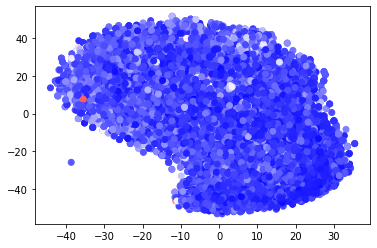

In [268]:
clinton_like = np.array(np.matmul(subreddit_tfidf_good_normalized, ppmi_sims[good_subreddit_reverse_dict['hillaryclinton']].T))[0]

plt.scatter(subreddit_tsne_points[good_users,0], subreddit_tsne_points[good_users,1], c = clinton_like, cmap = plt.cm.bwr)
plt.show()

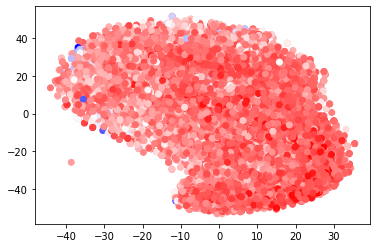

In [267]:
donald_not_sanders = np.array(np.matmul(subreddit_tfidf_good_normalized, 
                                        ppmi_sims[good_subreddit_reverse_dict['The_Donald']].T - ppmi_sims[good_subreddit_reverse_dict['SandersForPresident']].T))[0]

plt.scatter(subreddit_tsne_points[good_users,0], subreddit_tsne_points[good_users,1], c = donald_not_sanders, cmap = plt.cm.bwr)
plt.show()

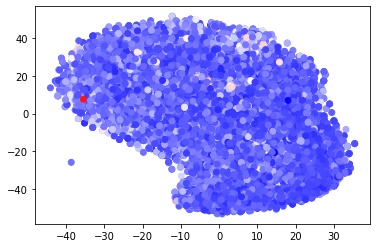

In [246]:
nba_not_warriors = np.array(np.matmul(subreddit_tfidf_good_normalized, 
                                        ppmi_sims[good_subreddit_reverse_dict['nba']].T - ppmi_sims[good_subreddit_reverse_dict['warriors']].T))[0]

plt.scatter(subreddit_tsne_points[good_users,0], subreddit_tsne_points[good_users,1], c = nba_not_warriors, cmap = plt.cm.bwr)
plt.show()

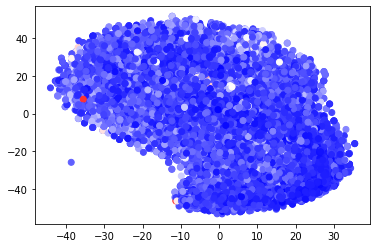

In [247]:
nba_like = np.array(np.matmul(subreddit_tfidf_good_normalized, 
                                        ppmi_sims[good_subreddit_reverse_dict['nba']].T))[0]

plt.scatter(subreddit_tsne_points[good_users,0], subreddit_tsne_points[good_users,1], c = nba_like, cmap = plt.cm.bwr)
plt.show()

In [222]:
subreddit_tfidf_good.sum(axis=1)

matrix([[0.07773555],
        [0.6834149 ],
        [0.10267273],
        ...,
        [0.        ],
        [0.70831563],
        [0.54125734]])

## Co-occurrence of specific types of subreddits

In [30]:
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['CoonTown']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['CoonTown']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['CoonTown']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['CoonTown']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['CoonTown']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['CoonTown']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['CoonTown']]).sum())

62
69
10
42
8
9
7


In [31]:
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['femalefashionadvice']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['femalefashionadvice']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['femalefashionadvice']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['femalefashionadvice']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['femalefashionadvice']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['femalefashionadvice']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['femalefashionadvice']]).sum())

16
56
10
10
3
6
2


In [32]:
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())

158
193
13
113
9
13
9


In [35]:
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())

743
1116
159
530
87
142
81


In [36]:
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['warriors']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['warriors']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['warriors']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['warriors']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['warriors']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['warriors']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['SandersForPresident']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['The_Donald']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['hillaryclinton']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['warriors']]).sum())

49
79
17
38
9
17
9


In [38]:
print(subreddit_df_mat[:, subreddit_reverse_dict['warriors']].sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['nba']].sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['warriors']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['warriors']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['nba']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).sum())
print(subreddit_df_mat[:, subreddit_reverse_dict['warriors']].multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nsfw_gifs']]).multiply(
    subreddit_df_mat[:, subreddit_reverse_dict['nba']]).sum())

183
2648
169
6
131
6
